In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
notshrirang_spotify_million_song_dataset_path = kagglehub.dataset_download('notshrirang/spotify-million-song-dataset')

print('Data source import complete.')

Data source import complete.


In [ ]:
# Print out the path to the Kaggle dataset
print(notshrirang_spotify_million_song_dataset_path)

/root/.cache/kagglehub/datasets/notshrirang/spotify-million-song-dataset/versions/1


# 🤖 DTSA 5510 - Clustering Spotify Million Song

**Owner**: Korkrid Kyle Akepanidtaworn, MSDS

# Project Description

* Spotify is a digital music streaming service that provides instant access to its vast online library of music and podcasts. You can listen to any content of your choice anytime. It is both legal and easy to use.
You will find millions of songs from various genres and artists, from obscure indie rock and top 40 pop, to movie soundtracks and classical music. It also has a complex algorithm to recommend music based on your listening history, curated playlists and internet radio station
* This project utilizes **the Spotify Million Song Dataset**, which includes song titles, artist names, song links, and lyrics. This dataset is suitable for various applications, such as song recommendation and classification. This project specifically explores different clustering techniques from the scikit-learn library.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/notshrirang/spotify-million-song-dataset/versions/1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/root/.cache/kagglehub/datasets/notshrirang/spotify-million-song-dataset/versions/1/spotify_millsongdata.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import tqdm  # Import tqdm for progress bars in loops
from collections import Counter
import nltk  # Import NLTK for text cleaning and processing
import re  # Regular expression module for text pattern matching
from nltk.corpus import stopwords  # NLTK stopwords list
from nltk.tokenize import word_tokenize  # Word tokenizer
from nltk.stem import WordNetLemmatizer  # Lemmatizer for reducing words to their base form
from nltk.util import ngrams  # N-gram utility for text analysis

# Ensure that necessary NLTK resources are downloaded
nltk.download('stopwords')  # Download stopwords list (common words to exclude from text)
nltk.download('punkt')  # Download tokenizer models
nltk.download('wordnet')  # Download WordNet lexicon for lemmatization
nltk.download('punkt_tab')  # Download tokenizer models for text segmentation

from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF vectorizer for text transformation
from sklearn.cluster import KMeans  # KMeans clustering algorithm
from sklearn.metrics import silhouette_score  # Metric for evaluating clustering quality
from sklearn.cluster import AgglomerativeClustering  # Agglomerative clustering for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage  # Dendrogram visualization for hierarchical clustering
from sklearn.metrics.pairwise import cosine_similarity  # Function for calculating cosine similarity between text vectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Load datasets into pandas DataFrames from CSV files
df = pd.read_csv("/root/.cache/kagglehub/datasets/notshrirang/spotify-million-song-dataset/versions/1/spotify_millsongdata.csv")

# Inspect data
print(df.head())

# Print overview of data
print(df.info())

# Perform basic data inspection such as getting the number of observations and number of features
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

  artist                   song                                        link  \
0   ABBA  Ahe's My Kind Of Girl  /a/abba/ahes+my+kind+of+girl_20598417.html   
1   ABBA       Andante, Andante       /a/abba/andante+andante_20002708.html   
2   ABBA         As Good As New        /a/abba/as+good+as+new_20003033.html   
3   ABBA                   Bang                  /a/abba/bang_20598415.html   
4   ABBA       Bang-A-Boomerang      /a/abba/bang+a+boomerang_20002668.html   

                                                text  
0  Look at her face, it's a wonderful face  \r\nA...  
1  Take it easy with me, please  \r\nTouch me gen...  
2  I'll never know why I had to go  \r\nWhy I had...  
3  Making somebody happy is a question of give an...  
4  Making somebody happy is a question of give an...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57

# Exploratory Data Analysis (EDA)

In [ ]:
# Check for missing values
df.isna().sum()

,0
artist,0
song,0
link,0
text,0


**Observation**: The data is complete, with no missing values.

Top 10 artists by number of songs:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Cher                187
Alabama             187
Reba Mcentire       187
Loretta Lynn        187
Dean Martin         186
Chaka Khan          186
Name: song, dtype: int64


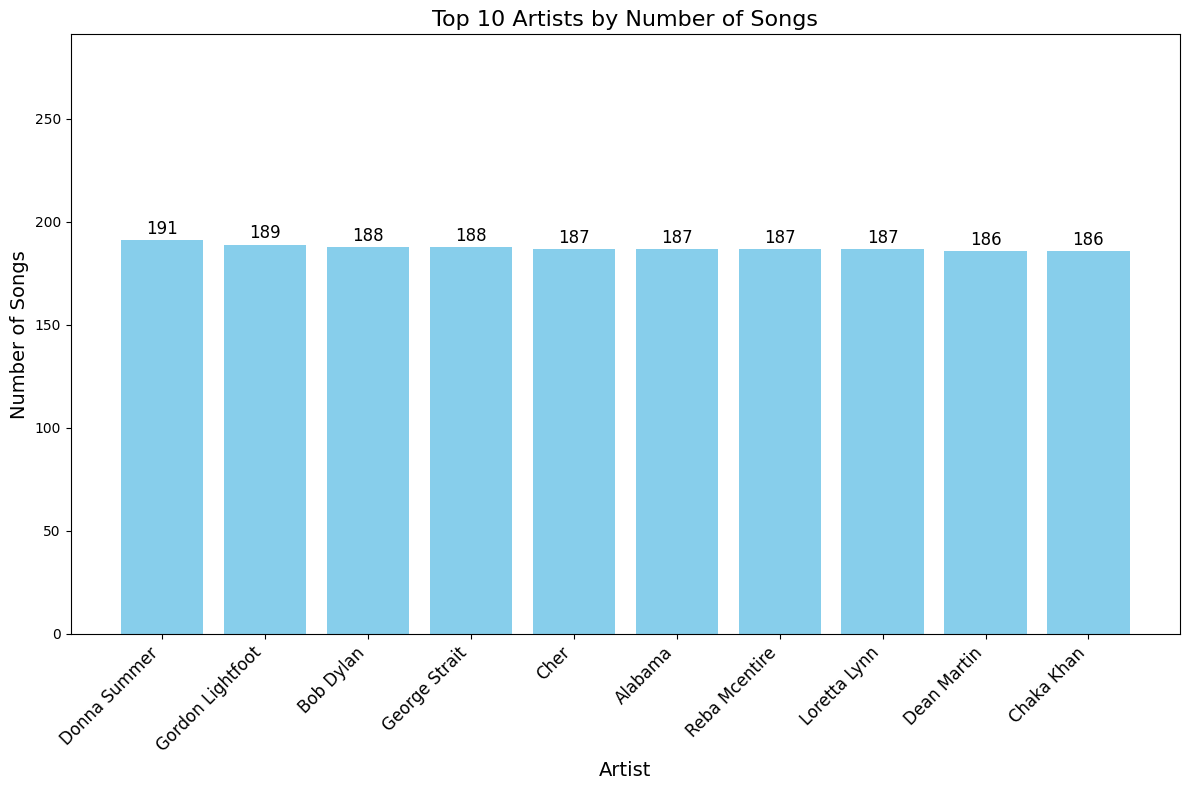

Execution completed in 0.46 seconds.


In [ ]:
# Start timing the process
start_time = time.time()

# Group the DataFrame by 'artist' and count the number of songs for each artist
artist_counts = df.groupby('artist')['song'].count()

# Sort the counts in descending order and select the top 10
top_10_artists = artist_counts.sort_values(ascending=False).head(10)

# Display Results
print("Top 10 artists by number of songs:")
print(top_10_artists)

# Plotting the Results
# Create a vertical bar plot
plt.figure(figsize=(12, 8))  # Adjust figure size for better readability
plt.bar(top_10_artists.index, top_10_artists.values, color='skyblue')  # Customize bar color
plt.xlabel('Artist', fontsize=14)
plt.ylabel('Number of Songs', fontsize=14)
plt.title('Top 10 Artists by Number of Songs', fontsize=16)
plt.ylim(0, top_10_artists.values.max() + 100)  # Add padding to the y-axis for better label placement

# Annotate Bars with Song Counts
# Loop through each bar and add text labels for the song counts
for i, v in enumerate(top_10_artists.values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=12)  # Offset for better visibility

# Final Touches
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and align x-axis labels
plt.tight_layout()  # Ensure the layout fits within the figure boundaries

# Display the plot
plt.show()

# Log Execution Time
end_time = time.time()
print(f"Execution completed in {end_time - start_time:.2f} seconds.")

**Observation**:

1. **Top Artist**: Donna Summer is the top artist with 191 songs.
2. **Close Competition**: The next few artists have very similar numbers of songs, with Gordon Lightfoot (189), Bob Dylan (188), and George Strait (188) being close behind.
3. **Even Distribution**: The top 10 artists have a relatively even distribution of songs, with the difference between the top and bottom artists being only 15 songs.

In [ ]:
# Function to clean and preprocess text
def clean_text(text):
    """
    Author: @Korkrid Kyle Akepanidtaworn, MSDS
    Cleans and preprocesses input text by performing the following steps:
    - Removes non-alphanumeric characters.
    - Converts text to lowercase.
    - Tokenizes the text.
    - Removes stopwords and personal pronouns.
    - Lemmatizes tokens to their base form.

    Parameters:
        text (str): Input text to be cleaned and processed.

    Returns:
        list: A list of cleaned and lemmatized tokens.
    """

    # Step 1: Remove non-alphanumeric characters (punctuation, symbols)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Step 2: Convert to lowercase for uniformity
    text = text.lower()

    # Step 3: Tokenize the text into words
    tokens = word_tokenize(text)

    # Step 4: Define stopwords and pronouns to filter out
    stop_words = set(stopwords.words('english'))
    pronouns = {'he', 'she', 'they', 'it', 'i', 'we', 'you', 'me', 'him', 'her', 'us', 'them'}

    # Step 5: Filter out stopwords and pronouns
    filtered_tokens = [word for word in tokens if word not in stop_words and word not in pronouns]

    # Step 6: Lemmatize tokens to their base form
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return lemmatized_tokens

# Example
example_text = "He loves programming! She's learning Python. They are excited to code together."
print(clean_text(example_text))

['love', 'programming', 'shes', 'learning', 'python', 'excited', 'code', 'together']


In [ ]:
# Function to provide top relevant 5 song recommendations.
def recommend_songs(df, song_title, top_n=5):
    """
    Author: @Korkrid Kyle Akepanidtaworn, MSDS
    Recommends songs based on cosine similarity of TF-IDF vectors.

    Args:
        df: DataFrame containing 'content' (combined text features) and 'song' columns.
        song_title: Title of the song for which recommendations are needed.
        top_n: Number of top recommendations to return.

    Returns:
        DataFrame: Top N recommended songs (based on similarity).
    """

    # Ensure the song title exists in the DataFrame
    if song_title not in df['song'].values:
        print(f"Song '{song_title}' not found in the dataset.")
        return pd.DataFrame()  # Return empty DataFrame if song not found

    # Step 1: Initialize the TF-IDF Vectorizer (removing common English stop words)
    vectorizer = TfidfVectorizer(stop_words='english')  # Convert text data into TF-IDF vectors
    X = vectorizer.fit_transform(df['content'])  # Apply the vectorizer to the 'content' column

    # Step 2: Find the index of the input song in the DataFrame
    song_index = df[df['song'] == song_title].index[0]

    # Step 3: Calculate the cosine similarity between the input song's vector and all other song vectors
    similarity_scores = cosine_similarity(X[song_index], X)

    # Step 4: Get the indices of the most similar songs (excluding the input song itself)
    similar_song_indices = similarity_scores.argsort()[0][-top_n-1:-1][::-1]

    # Step 5: Create a DataFrame of the recommended songs based on the similar indices
    recommendations = df.iloc[similar_song_indices][['artist', 'song']]
    recommendations.reset_index(inplace=True, drop=True)  # Reset the index for neatness

    # Return the DataFrame containing the recommendations
    return recommendations

# Example
print(recommend_songs(df, "Bang-A-Boomerang"))

          artist            song
0           ABBA            Bang
1  Jimmy Buffett  Boomerang Love
2           Kiss       Boomerang
3     Zeromancer         Wannabe
4  Queen Adreena  Friday's Child


## Bi-gram Analysis

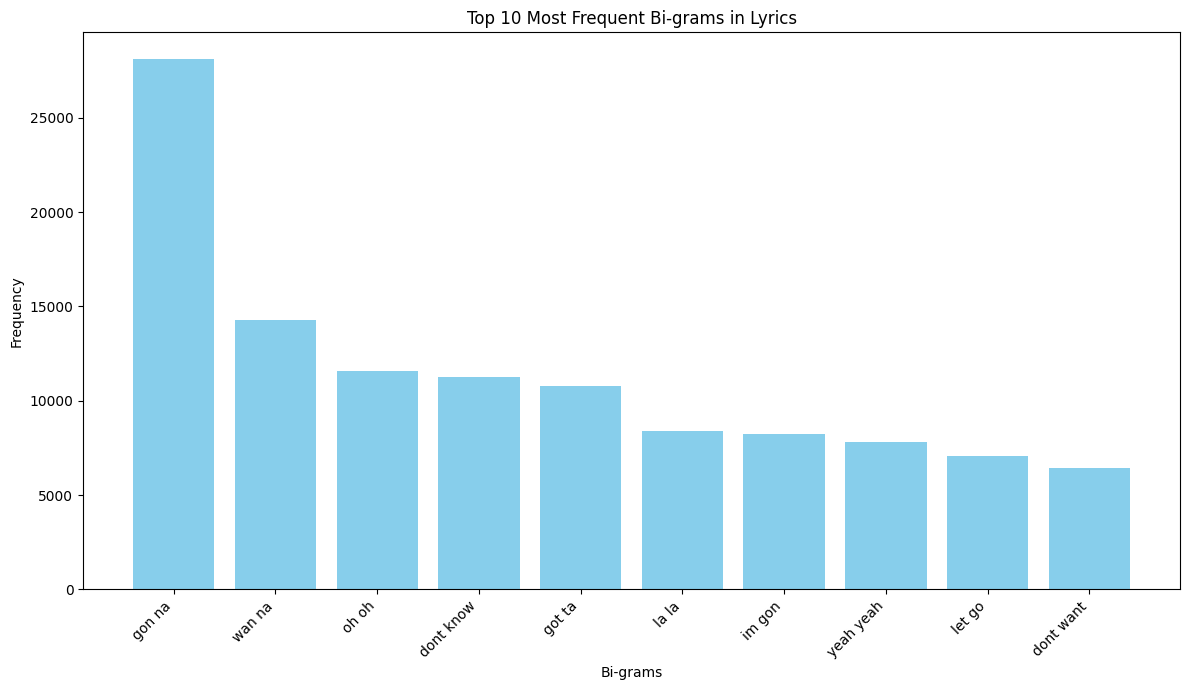

In [ ]:
# Combine all lyrics into a single string
all_lyrics = ' '.join(df['text'])

# Clean and tokenize the lyrics using a custom cleaning function
tokens = clean_text(all_lyrics)

# Generate bi-grams (pairs of consecutive words)
bigrams = list(ngrams(tokens, 2))

# Count the frequency of each bi-gram
bigram_counts = Counter(bigrams)

# Get the top 10 most frequent bi-grams
top_bigrams = bigram_counts.most_common(10)

# Prepare bi-grams and their counts for plotting
bigram_phrases = [' '.join(bigram) for bigram, _ in top_bigrams]
bigram_frequencies = [count for _, count in top_bigrams]

# Plot the top bi-grams
plt.figure(figsize=(12, 7))
plt.bar(bigram_phrases, bigram_frequencies, color='skyblue')
plt.xlabel('Bi-grams')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Bi-grams in Lyrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

**Observation**: The plot identifies the most frequent bi-grams (two-word phrases) in the song lyrics. `Gon na` is the most common, followed by `wan na,` `oh oh,` and others. The presence of contractions like `gon na` and `wan na` suggests their frequent use in song lyrics, likely for rhythmic and poetic purposes. Bi-grams like `oh oh` and `yeah yeah` often express emotions such as surprise, excitement, or agreement, indicating their role in conveying feelings through music. These are common songwriting techniques used to create catchy and memorable phrases.

## Tri-gram Analysis

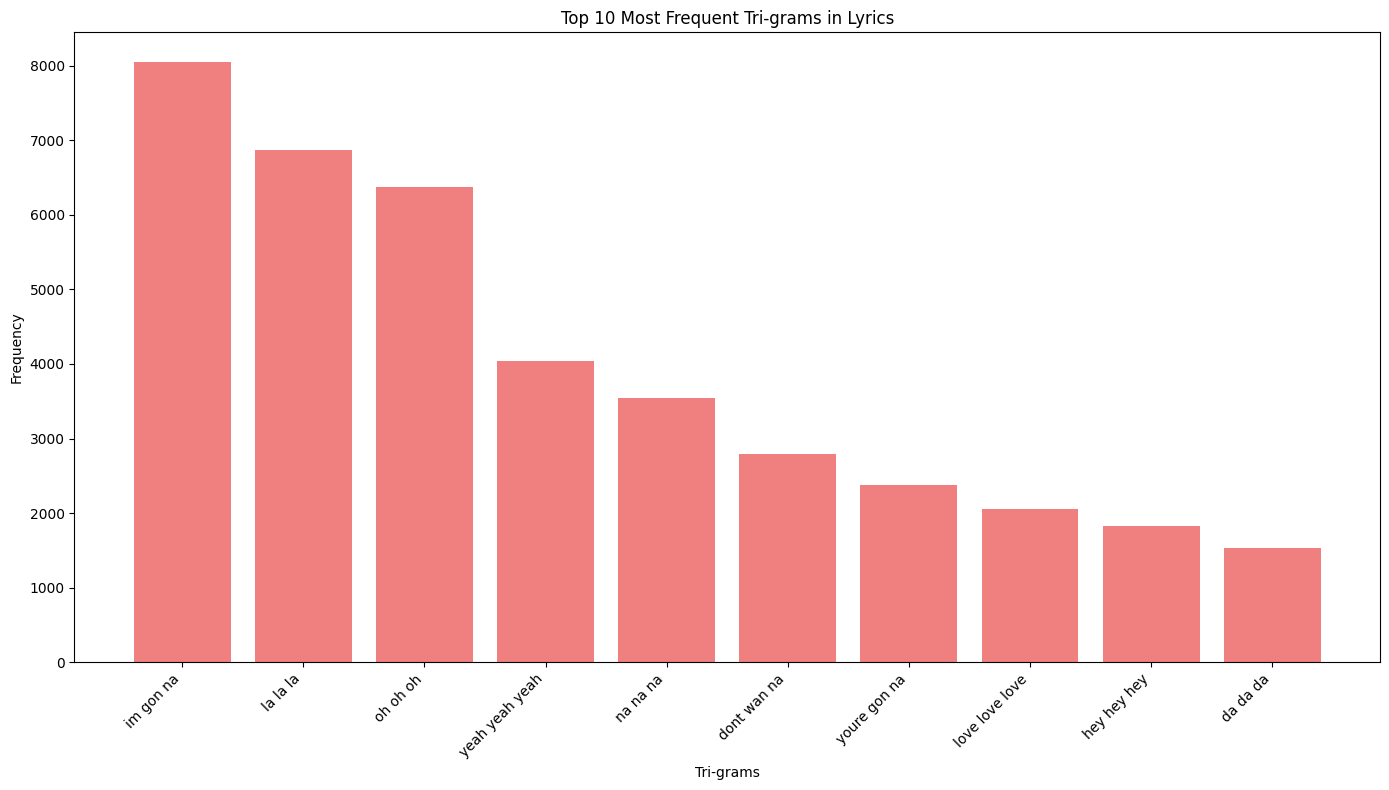

In [ ]:
# Combine all lyrics into a single string
all_lyrics = ' '.join(df['text'])

# Clean and tokenize the lyrics using a custom cleaning function
tokens = clean_text(all_lyrics)

# Generate tri-grams (sequences of three consecutive words)
trigrams = list(ngrams(tokens, 3))

# Count the frequency of each tri-gram
trigram_counts = Counter(trigrams)

# Get the top 10 most frequent tri-grams
top_trigrams = trigram_counts.most_common(10)

# Prepare tri-grams and their counts for plotting
trigram_phrases = [' '.join(trigram) for trigram, _ in top_trigrams]
trigram_frequencies = [count for _, count in top_trigrams]

# Plot the top tri-grams
plt.figure(figsize=(14, 8))
plt.bar(trigram_phrases, trigram_frequencies, color='lightcoral')
plt.xlabel('Tri-grams')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Tri-grams in Lyrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()

**Observation**:  The plot reveals the most commonly used tri-grams in song lyrics. `im gon na` takes the lead, followed by `la la la,` `oh oh oh,` and so on. It highlights the common phrases that resonate with listeners and contribute to the overall musical experience.

# Model Building and Training

Clustering is an unsupervised learning technique that identifies groups of similar entities within a dataset without predefined labels.

**The Spotify Million Song Dataset** - which includes song titles, artist names, song links, and lyrics - offers a valuable opportunity for clustering analysis. I will compare and contrast different popular clustering techniques:

* K-Means Clustering
* Hierarchical Clustering

As this dataset can also be used for song recommendation, I will implement a simple recommendation system and discuss the results.

## K-Means Clustering

The K-means clustering algorithm computes centroids and repeats until the optimal centroid is found. It is presumptively known how many clusters there are. It is also known as the flat clustering algorithm. The optimal number of clusters found from data by the method is denoted by the letter `K` in K-means. In this method, data points are assigned to initial clusters in such a way that the sum of the squared distances between the data points and the centroid is as small as possible. It is essential to note that reduced diversity within clusters leads to more identical data points within the same cluster.

The K-Means algorithm operates as follows:

1.  **Initialization**: Specify the desired number of clusters, k.
2.  **Random Initialization**: Randomly select k data points as initial cluster centroids.
3. **Iterative Refinement**:
  * Assignment Step: Assign each data point to the nearest cluster centroid based on Euclidean distance.
  * Update Step: Recalculate the centroid of each cluster by averaging the assigned data points.
4. **Convergence**: Repeat steps 3 until convergence, i.e., when centroid assignments no longer change significantly.

K-Means employs an **Expectation-Maximization (EM)** approach. The Expectation step assigns data points to the nearest cluster, while the Maximization step updates cluster centroids.

[INFO] Combining 'artist', 'song', and 'text' into a single content field...
[INFO] Generating TF-IDF vectors...
[INFO] TF-IDF matrix shape: (57650, 82985)
[INFO] Running the elbow method to find optimal k...


100%|██████████| 9/9 [09:36<00:00, 64.05s/it]


[INFO] Elbow method completed in 576.45 seconds.


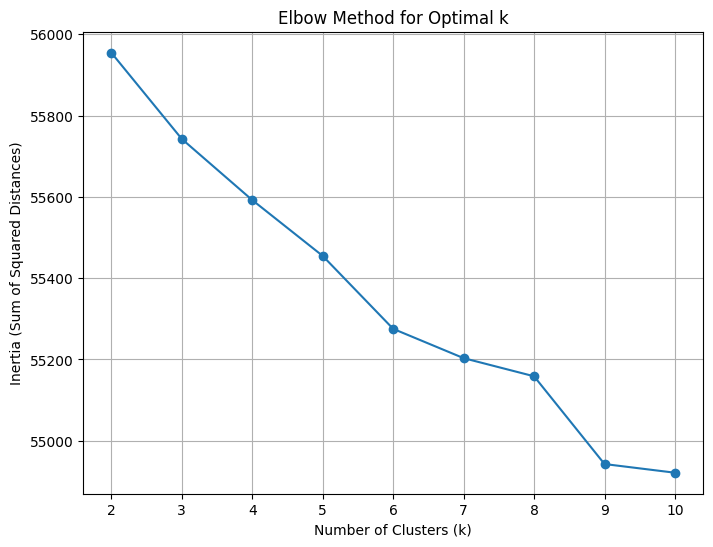

[INFO] Performing silhouette analysis...
Silhouette score for k=2: 0.0008
Silhouette score for k=3: -0.0008
Silhouette score for k=4: -0.0006
Silhouette score for k=5: -0.0003
Silhouette score for k=6: 0.0019
Silhouette score for k=7: 0.0008
Silhouette score for k=8: 0.0011
Silhouette score for k=9: 0.0024
Silhouette score for k=10: 0.0018
[INFO] Silhouette analysis completed in 2406.06 seconds.


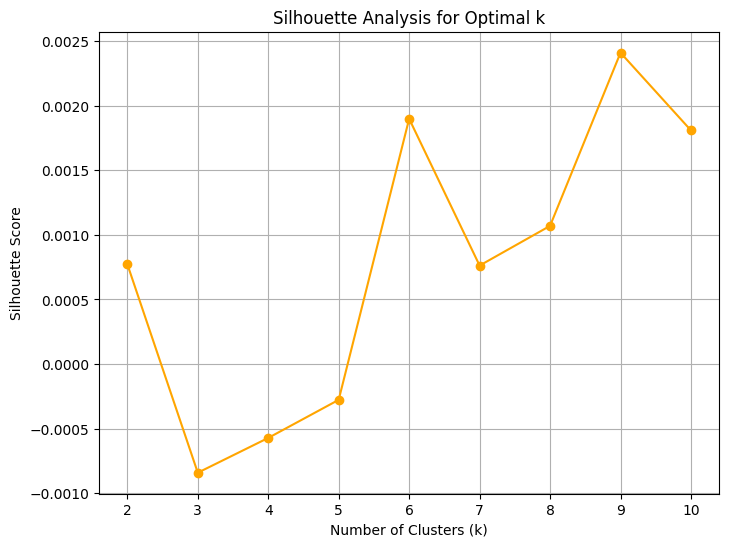

[INFO] Optimal number of clusters (k) determined: 9
[INFO] Applying K-means clustering with k=9...
[INFO] Clustering completed in 83.74 seconds.
[INFO] Cluster sizes:
cluster
2    26817
5    11516
0     7373
7     3730
4     3475
3     2121
6     1717
1      557
8      344
Name: count, dtype: int64

[INFO] Cluster 0 example songs:
   artist                song  \
5    ABBA  Burning My Bridges   
31   ABBA       Hey Hey Helen   
32   ABBA   Hole In Your Soul   
47   ABBA      King Kong Song   
55   ABBA              Lovers   

                                                 text  
5   Well, you hoot and you holler and you make me ...  
31  So at last you're free  \r\nIt's the way you w...  
32  You feel bad, let me tell you, we all get the ...  
47  Well I was looking at a movie on the TV last n...  
55  Sit down and listen 'cause I've got good news ...  

[INFO] Cluster 1 example songs:
      artist                           song  \
107     ABBA  We Wish You A Merry Christmas   
364  

In [ ]:
# Start tracking overall execution time
start_time = time.time()

# Combine 'artist', 'song', and 'text' into a single content field
print("[INFO] Combining 'artist', 'song', and 'text' into a single content field...")
df['content'] = df['artist'] + ' ' + df['song'] + ' ' + df['text']

# Create TF-IDF vectors
print("[INFO] Generating TF-IDF vectors...")
vectorizer = TfidfVectorizer(stop_words='english')  # Removes common English stop words
X = vectorizer.fit_transform(df['content'])
print(f"[INFO] TF-IDF matrix shape: {X.shape}")

# Find the optimal number of clusters (k) using the elbow method
print("[INFO] Running the elbow method to find optimal k...")
inertia = []
elbow_start_time = time.time()

for k in tqdm.tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # n_init ensures stability across runs
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

print(f"[INFO] Elbow method completed in {time.time() - elbow_start_time:.2f} seconds.")

# Plot the elbow method results
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Silhouette analysis to refine the choice of k
print("[INFO] Performing silhouette analysis...")
silhouette_scores = []
silhouette_start_time = time.time()

for k in tqdm.tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette score for k={k}: {silhouette_avg:.4f}")

print(f"[INFO] Silhouette analysis completed in {time.time() - silhouette_start_time:.2f} seconds.")

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True)
plt.show()

# Programmatically choose the optimal k based on the analysis
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # Adjust index to match k range
print(f"[INFO] Optimal number of clusters (k) determined: {optimal_k}")

# Apply K-means clustering with the chosen k
print(f"[INFO] Applying K-means clustering with k={optimal_k}...")
clustering_start_time = time.time()
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)
print(f"[INFO] Clustering completed in {time.time() - clustering_start_time:.2f} seconds.")

# Print cluster sizes
print("[INFO] Cluster sizes:")
print(df['cluster'].value_counts())

# Display example songs from each cluster
for cluster_num in range(optimal_k):
    print(f"\n[INFO] Cluster {cluster_num} example songs:")
    print(df[df['cluster'] == cluster_num][['artist', 'song', 'text']].head())

# Print total execution time
print(f"\n[INFO] Total execution time: {time.time() - start_time:.2f} seconds.")

**Observation**: For the Spotify Million Song Dataset, The elbow method is a common technique used to determine the optimal number of clusters (k) in K-means clustering. It involves plotting the Within-Cluster Sum of Squares (WCSS) against the number of clusters. As the number of clusters increases, 1  WCSS generally decreases. The optimal number of clusters is typically identified at the 'elbow point,' where the rate of decrease in WCSS begins to level off.

Additionally, I calculate the silhouette score for different values of k and select the value that maximizes the average silhouette score. This indicates optimal cluster separation. Based on the results, I conclude that the optimal number of clusters is **9**, categorized by song content.

A closer examination reveals that Cluster 1 primarily consists of Christmas songs, while Cluster 3 contains predominantly rock 'n roll songs. Cluster 6, on the other hand, is composed of sad, melancholic songs.

K-Means clustering is a simple and widely used algorithm, particularly effective for high-dimensional data. It tends to produce tight clusters. However, its performance can be influenced by factors such as the initial choice of cluster centroids and the order of data points. Additionally, the algorithm can be computationally expensive for large datasets

## Hierarchical Clustering

While hierarchical clustering was considered, its computational complexity and potential performance issues on high-dimensional datasets make it unsuitable for this project. Like K-Means clustering, hierarchical clustering is an unsupervised learning technique that does not require a target variable. However, it can be computationally expensive, especially for large datasets. Due to the large number of data points, visualizing the dendrogram is impractical.

## Recommender System

Spotify is a well-known use case for recommendation engines. To recommend songs based on lyrical similarity, I employ a TF-IDF-based cosine similarity approach.

**TF-IDF Vectorization:**

1. **Tokenization**: Break down song lyrics into individual words (tokens).
2. **Term Frequency (TF)**: Calculate the frequency of each word within a song.
3. **Inverse Document Frequency (IDF)**: Measure the rarity of a word across the entire dataset.
4. **TF-IDF Weighting**: Multiply TF and IDF for each word to generate a weighted vector representing the song's semantic content.

**Cosine Similarity Calculation:**

1. **Vector Comparison:** Calculate the cosine similarity between the TF-IDF vector of a chosen song and all other songs in the dataset.
2. **Similarity Scoring**: A higher cosine similarity score indicates greater semantic similarity between two songs.

**Recommendation Generation:**

1. **Ranking**: Sort songs by their cosine similarity score with the chosen song.
2. **Recommendation**: Display the top-ranked songs as recommendations to the user.

The following script demonstrates the practical implementation of this song recommendation function.

In [ ]:
# Start time logging for performance tracking
start_time = time.time()

# Assuming 'df' is your DataFrame with song information and text content
song_to_recommend = "Friend"  # Replace with the song you want recommendations for

# Call the function to get the recommendations
recommended_songs_df = recommend_songs(df, song_to_recommend)

# If recommendations were found, print them; otherwise, notify user
if not recommended_songs_df.empty:
    print(f"Recommended songs similar to '{song_to_recommend}':")
    print(recommended_songs_df)

# End time logging and print execution duration
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution completed in {execution_time:.4f} seconds.")

Recommended songs similar to 'Friend':
              artist                  song
0           Iggy Pop              Sickness
1       Foo Fighters           On The Mend
2            'n Sync   Tearing Up My Heart
3  Steve Miller Band             My Friend
4            Rainbow  Tearin' Out My Heart
Execution completed in 13.6997 seconds.


**Observation**: I'd like to demonstrate a list of songs recommended to be similar to the song `Friend`.

**Song Recommendations:**

1. Iggy Pop - Sickness: This is an interesting recommendation because Iggy Pop is known for his punk rock style, which is quite different from the typical sound of "Friend." However, the recommendation system might have identified similarities in the emotional intensity or the raw energy of the songs.
2. Foo Fighters - On The Mend: The Foo Fighters are a rock band, and their song. "On The Mend" might share similarities with "Friend" in terms of musical style or the overall mood and message.
3. 'N Sync - Tearing Up My Heart: This is another unexpected recommendation, as 'N Sync is a pop group known for their catchy tunes and upbeat music. However, the recommendation system might have found common ground in the emotional themes of the songs, particularly the theme of heartbreak or longing.
4. Steve Miller Band - My Friend: This recommendation is perhaps the most straightforward, as the song title itself is similar to "Friend." Both songs might share a theme of friendship or camaraderie.
5. Rainbow - Tearin' Out My Heart: Similar to 'N Sync's recommendation, Rainbow is a rock band known for their powerful vocals and energetic performances. The recommendation system might have identified similarities in the emotional intensity or the dramatic nature of the songs.

In [ ]:
# Start time logging for performance tracking
start_time = time.time()

# Assuming 'df' is your DataFrame with song information and text content
song_to_recommend = "I'm Money"  # Replace with the song you want recommendations for

# Call the function to get the recommendations
recommended_songs_df = recommend_songs(df, song_to_recommend, 10)

# If recommendations were found, print them; otherwise, notify user
if not recommended_songs_df.empty:
    print(f"Recommended songs similar to '{song_to_recommend}':")
    print(recommended_songs_df)

# End time logging and print execution duration
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution completed in {execution_time:.4f} seconds.")

Recommended songs similar to 'I'm Money':
                artist                      song
0          Roy Orbison                     Money
1  Grand Funk Railroad   All You've Got Is Money
2       Britney Spears               Intimidated
3                Doors                     Money
4             R. Kelly                     Hotel
5                Ne-Yo           Cause I said so
6                 Rush             The Big Money
7             Fabolous  Money Money Money Shouts
8        Avril Lavigne  I Always Get What I Want
9               J Cole                  Mo Money
Execution completed in 13.7128 seconds.


**Observation**: Another example is a list of songs recommended to be similar to the song `I'm Money`.

**Song Recommendations:**

1. Roy Orbison - Money: This is the most obvious recommendation, as the song title itself is similar to "I'm Money". Both songs might share a theme of money or wealth.
2. Grand Funk Railroad - All You've Got Is Money: This recommendation is also quite straightforward, as the song title directly references money. Both songs might explore the theme of money in a similar way.
3. Britney Spears - Intimidated: This is an interesting recommendation, as Britney Spears is known for her pop music, which is quite different from the typical sound of "I'm Money". However, the recommendation system might have identified similarities in the themes of confidence or self-assurance.
4. The Doors - Money: This recommendation is similar to the first one, as both songs share the same title. Both songs might explore the theme of money in a different way, perhaps with a more psychedelic or experimental approach.
5. R. Kelly - Hotel: This is another unexpected recommendation, as R. Kelly is known for his R&B and hip-hop music. However, the recommendation system might have found common ground in the themes of luxury or indulgence.
6. Ne-Yo - Cause I said so: This recommendation is also quite unexpected, as Ne-Yo is known for his romantic ballads. However, the recommendation system might have found similarities in the themes of confidence or assertiveness.
7. Rush - The Big Money: This is another interesting recommendation, as Rush is a progressive rock band known for their complex musical arrangements. However, the recommendation system might have identified similarities in the themes of ambition or success.
8. Fabolous - Money Money Money Shouts: This recommendation is quite straightforward, as the song title directly references money. Both songs might explore the theme of money in a similar way, perhaps with a more boastful or celebratory tone.
9. Avril Lavigne - I Always Get What I Want: This recommendation is similar to the Britney Spears recommendation, as both songs might explore the theme of confidence or self-assurance.
10. J Cole - Mo Money: This recommendation is similar to the Roy Orbison and Grand Funk Railroad recommendations, as the song title directly references money. Both songs might explore the theme of money in a similar way, perhaps with a more reflective or critical approach.

# Conclusion

1. **Top Artist**: Donna Summer is the most represented artist with 191 songs.
2. **Common Phrases**: The most frequent tri-grams in song lyrics are "im gon na," "la la la," "oh oh oh," and others. These phrases likely contribute to the overall musical experience and listener appeal.
3. **Optimal Clustering:** The optimal number of clusters, determined through the elbow method and silhouette analysis, is 9. These clusters are categorized by song content, with examples including Christmas songs, rock 'n roll, and melancholic songs. Hierarchical clustering was not suitable due to the large dataset and computational complexity.
4. **Song Recommendation:** A TF-IDF-based cosine similarity approach was used to develop a song recommendation function. It's important to note that these recommendations are algorithmic and may not perfectly align with individual preferences. Musical taste is subjective, and what one person finds similar, another may not.

# Additonal Resources

- [What is Spotify, how does it work, and is it free? - Android Authority](https://www.androidauthority.com/what-is-spotify-1129032/)
- [Machine Learning With Python and SciKit Learn (SKLearn) | by Mohamad Mahmood | Dev Genius](https://blog.devgenius.io/machine-learning-with-python-and-scikit-learn-sklearn-1607cd5e9c96)
- [How to Evaluate Clustering Algorithms?](https://www.analyticsvidhya.com/blog/2020/10/quick-guide-to-evaluation-metrics-for-supervised-and-unsupervised-machine-learning/)
- [Elbow Method to Find the Optimal Number of Clusters in K-Means](https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/)
- [Understanding K-Means Clustering Algorithm](https://www.analyticsvidhya.com/blog/2021/11/understanding-k-means-clustering-in-machine-learningwith-examples/)
- [Spotify Million Song Dataset](https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset)
- [K Means Clustering: Method to get most optimal K value](https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/)
- [TF-IDF and similarity scores | Chan`s Jupyter](https://goodboychan.github.io/python/datacamp/natural_language_processing/2020/07/17/04-TF-IDF-and-similarity-scores.html#:~:text=As%20you%20will%20see%20in,highest%20similarity%20score%20%28of%201%29)
- [Music Recommendation System](https://ijcttjournal.org/2023/Volume-71%20Issue-5/IJCTT-V71I5P105.pdf)
- [GitHub - namngduc/MiRemd: Content-based music recommendation system using Deep Learning and Cosine Similarity built with Pytorch](https://github.com/namngduc/MiRemd)